In [1]:
import random
import glob
import os

import cv2
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
directory = 'data'

Xs = []
ys = []

for x_file in glob.glob('data/X*.npy'):
    y_file = x_file.replace('X', 'y')
    with open(x_file, 'rb') as f:
        Xs.append(np.load(f))
    with open(y_file, 'rb') as f:
        ys.append(np.load(f))

X = np.concatenate(Xs)
y = np.concatenate(ys)
print(X.shape)
print(y.shape)

(8017, 128, 160, 3)
(8017,)


(70, 160, 3)


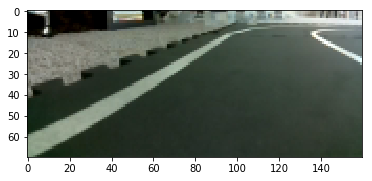

In [3]:
height = 70

def crop(img):
    return img[-height:, :]

x = crop(X[random.randint(0, len(X)-1)])
print(x.shape)
plt.imshow(x)

(70, 160)


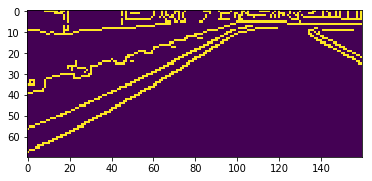

In [4]:
canny_thresh_1, canny_thresh_2 = 100, 200

def edges(img):
    return cv2.Canny(img, canny_thresh_1, canny_thresh_2)

x = edges(crop(X[random.randint(0, len(X)-1)]))
print(x.shape)
plt.imshow(x)

In [5]:
min_val, max_val, mid_val = y.min(), y.max(), (y.min() + y.max())/2.
print(min_val, max_val, mid_val)

-45.0 45.0 0.0


In [6]:
def preprocess_X(X):
    X_new = []
    for img in X:
        img_edge = edges(crop(img))
        img_edge = np.expand_dims(img_edge, 2)
        img_edge = np.array(img_edge, dtype=np.float32) / 255.0
        X_new.append(img_edge)
    return np.array(X_new)

def preprocees_y(y):
    return (y - mid_val) / (max_val - min_val)

X_pcd = preprocess_X(X)
y_pcd = preprocees_y(y)
print(X_pcd.shape)
print(y_pcd.shape)

(8017, 70, 160, 1)
(8017,)


In [7]:
p = np.random.permutation(len(X))

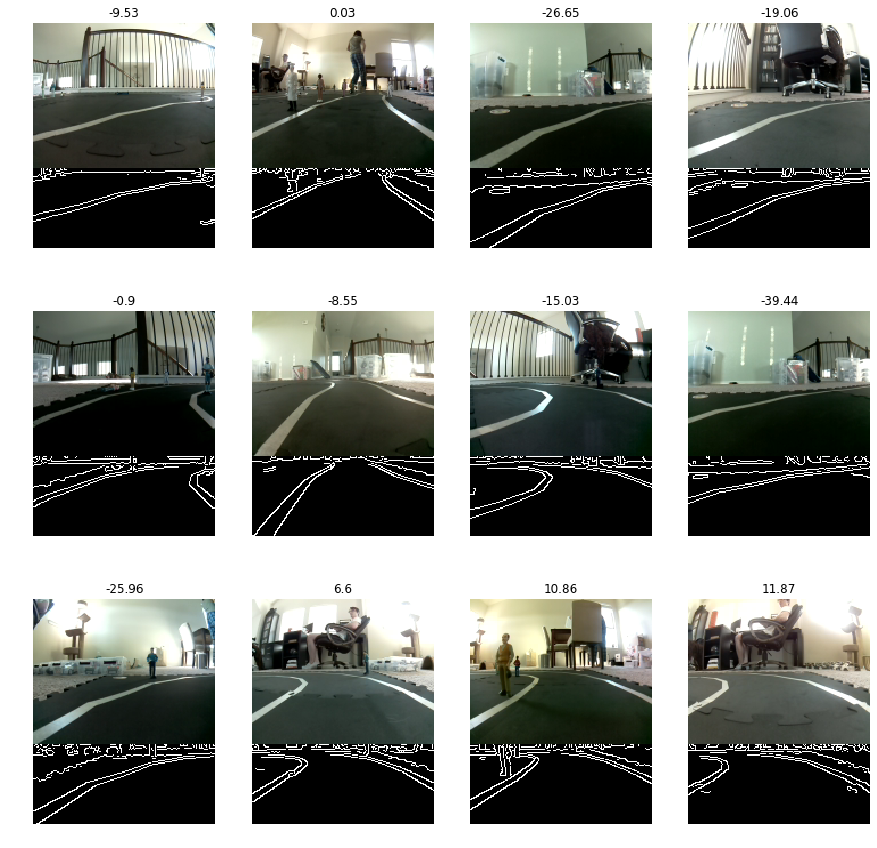

In [8]:
fig, axes = plt.subplots(3, 4, figsize=(15,15))

for img, img_pcd, label, ax in zip(X[p], X_pcd[p], y[p], axes.flatten()):
    img_pcd = np.array(cv2.cvtColor(img_pcd * 255.0, cv2.COLOR_GRAY2RGB), dtype=np.uint8)
    ax.imshow(np.concatenate((img, img_pcd), axis=0))
    ax.axis('off')
    ax.set_title(str(round(label, 2)))

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_pcd, y_pcd, test_size=0.2)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6413, 70, 160, 1)
(1604, 70, 160, 1)
(6413,)
(1604,)


In [10]:
def augment(X, y):
    X_new = []
    y_new = []
    for img, label in zip(X, y):
        X_new.append(img)
        y_new.append(label)
        X_new.append(np.fliplr(img))
        y_new.append(-label)
    return np.array(X_new), np.array(y_new)

X_train, y_train = augment(X_train, y_train)
X_test, y_test = augment(X_test, y_test)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(12826, 70, 160, 1)
(3208, 70, 160, 1)
(12826,)
(3208,)


Text(0.5, 1.0, '-0.23   0.23')

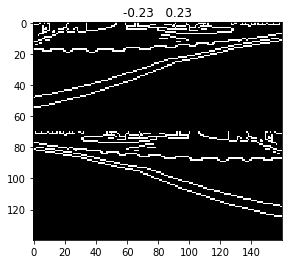

In [13]:
plt.imshow(cv2.cvtColor(np.concatenate((X_train[0], X_train[1]), axis=0), cv2.COLOR_GRAY2RGB))
plt.title("{}   {}".format(round(y_train[0], 2), round(y_train[1], 2)))

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Convolution2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from tensorflow.keras import callbacks

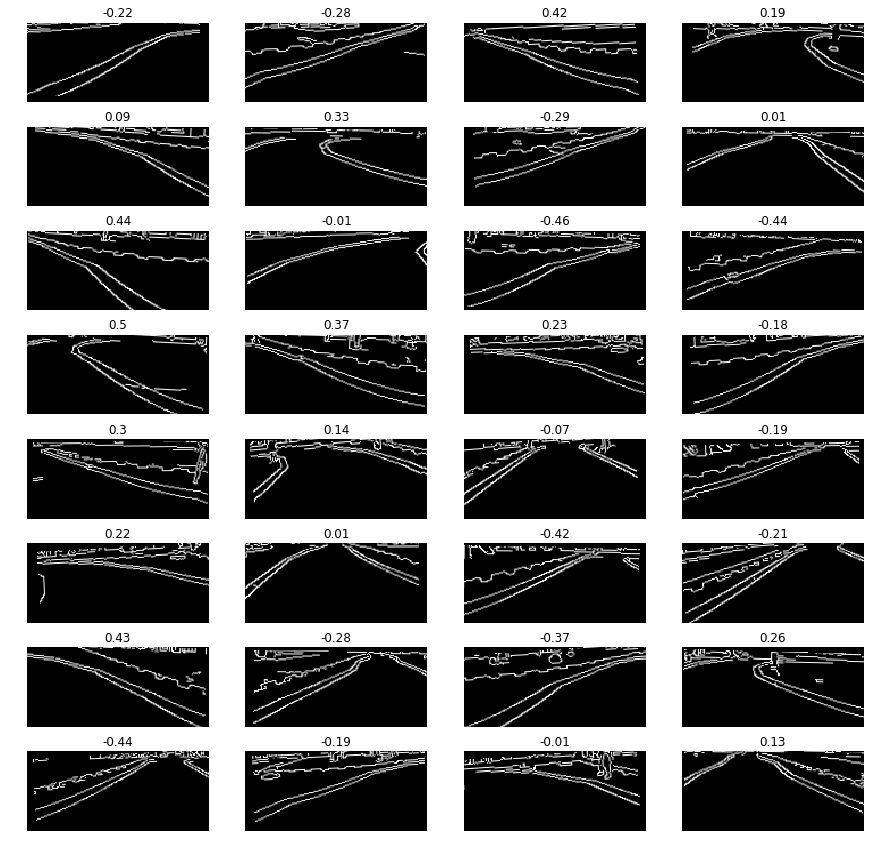

In [15]:
gen = ImageDataGenerator(featurewise_center=False,
                         samplewise_center=False,
                         featurewise_std_normalization=False,
                         samplewise_std_normalization=False,
                         zca_whitening=False,
                         rotation_range=5.0,
                         width_shift_range=0.05,
                         height_shift_range=0.05,
                         shear_range=0.0,
                         zoom_range=0.05,
                         channel_shift_range=0.0,
                         fill_mode='constant',
                         cval=0.0,
                         horizontal_flip=False,
                         vertical_flip=False,
                         rescale=None,
                         preprocessing_function=None)

fig, axes = plt.subplots(8, 4, figsize=(15, 15))

for X_batch, y_batch in gen.flow(X_train, y_train, batch_size=len(axes.flatten())):
    for img, label, ax in zip(X_batch, y_batch, axes.flatten()):
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_GRAY2BGR))
        ax.axis('off')
        ax.set_title(str(round(label, 2)))
    break

In [16]:
img_in = Input(shape=X_train.shape[1:], name='img_in')
angle_in = Input(shape=(1,), name='angle_in')

x = Convolution2D(4, (3, 3))(img_in)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Convolution2D(8, (3, 3))(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(3, 3))(x)

x = Convolution2D(16, (3, 3))(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(3, 3))(x)

merged = Flatten()(x)

x = Dense(16)(merged)
x = Activation('linear')(x)
x = Dropout(.2)(x)

angle_out = Dense(1, name='angle_out')(x)

model = Model(inputs=[img_in], outputs=[angle_out])
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_in (InputLayer)          (None, 70, 160, 1)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 68, 158, 4)        40        
_________________________________________________________________
activation (Activation)      (None, 68, 158, 4)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 34, 79, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 77, 8)         296       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 77, 8)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 25, 8)         0         
__________

In [17]:
save_path = 'model_01.hdf5'

save_best = callbacks.ModelCheckpoint(save_path, monitor='val_loss', verbose=2,
                                      save_best_only=True)

early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10,
                                     verbose=2)

callbacks_list = [save_best, early_stop]

In [18]:
batch_size = 128

model.fit_generator(gen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(X_train) // batch_size,
                    epochs=500,
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=2)

Epoch 1/500

Epoch 00001: val_loss improved from inf to 0.03029, saving model to model_01.hdf5
 - 18s - loss: 0.0305 - val_loss: 0.0303
Epoch 2/500

Epoch 00002: val_loss did not improve from 0.03029
 - 18s - loss: 0.0205 - val_loss: 0.0321
Epoch 3/500

Epoch 00003: val_loss did not improve from 0.03029
 - 19s - loss: 0.0191 - val_loss: 0.0319
Epoch 4/500

Epoch 00004: val_loss improved from 0.03029 to 0.03010, saving model to model_01.hdf5
 - 18s - loss: 0.0176 - val_loss: 0.0301
Epoch 5/500

Epoch 00005: val_loss improved from 0.03010 to 0.02785, saving model to model_01.hdf5
 - 18s - loss: 0.0174 - val_loss: 0.0279
Epoch 6/500

Epoch 00006: val_loss improved from 0.02785 to 0.02499, saving model to model_01.hdf5
 - 18s - loss: 0.0168 - val_loss: 0.0250
Epoch 7/500

Epoch 00007: val_loss did not improve from 0.02499
 - 18s - loss: 0.0162 - val_loss: 0.0275
Epoch 8/500

Epoch 00008: val_loss improved from 0.02499 to 0.02396, saving model to model_01.hdf5
 - 18s - loss: 0.0163 - val_lo

In [19]:
model = load_model('model_01.hdf5')

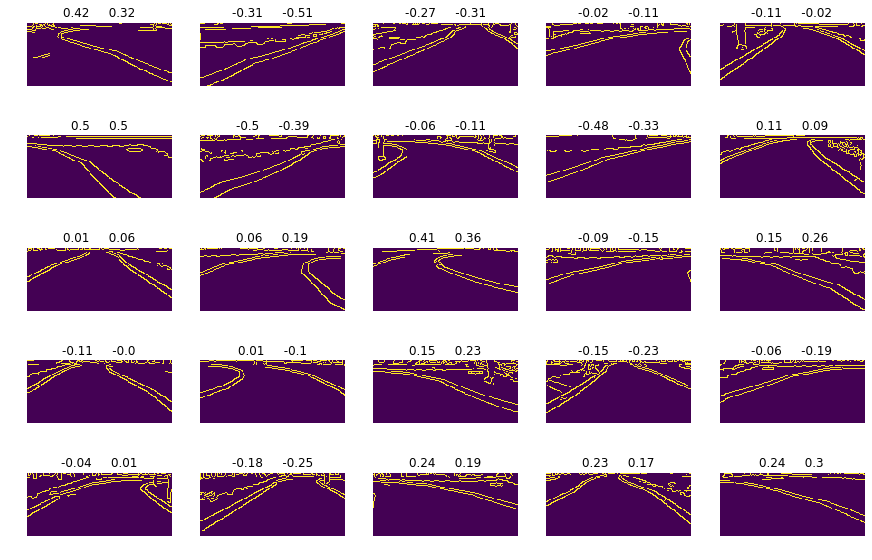

In [20]:
p = np.random.permutation(len(X_test))

fig, axes = plt.subplots(5, 5, figsize=(15,10))

for img, label, ax in zip(X_test[p], y_test[p], axes.flatten()):
    pred = round(model.predict(np.expand_dims(img, axis=0))[0][0], 2)
    ax.imshow(np.squeeze(img))
    ax.axis('off')
    ax.set_title(str(round(label, 2)) + "     " + str(pred))

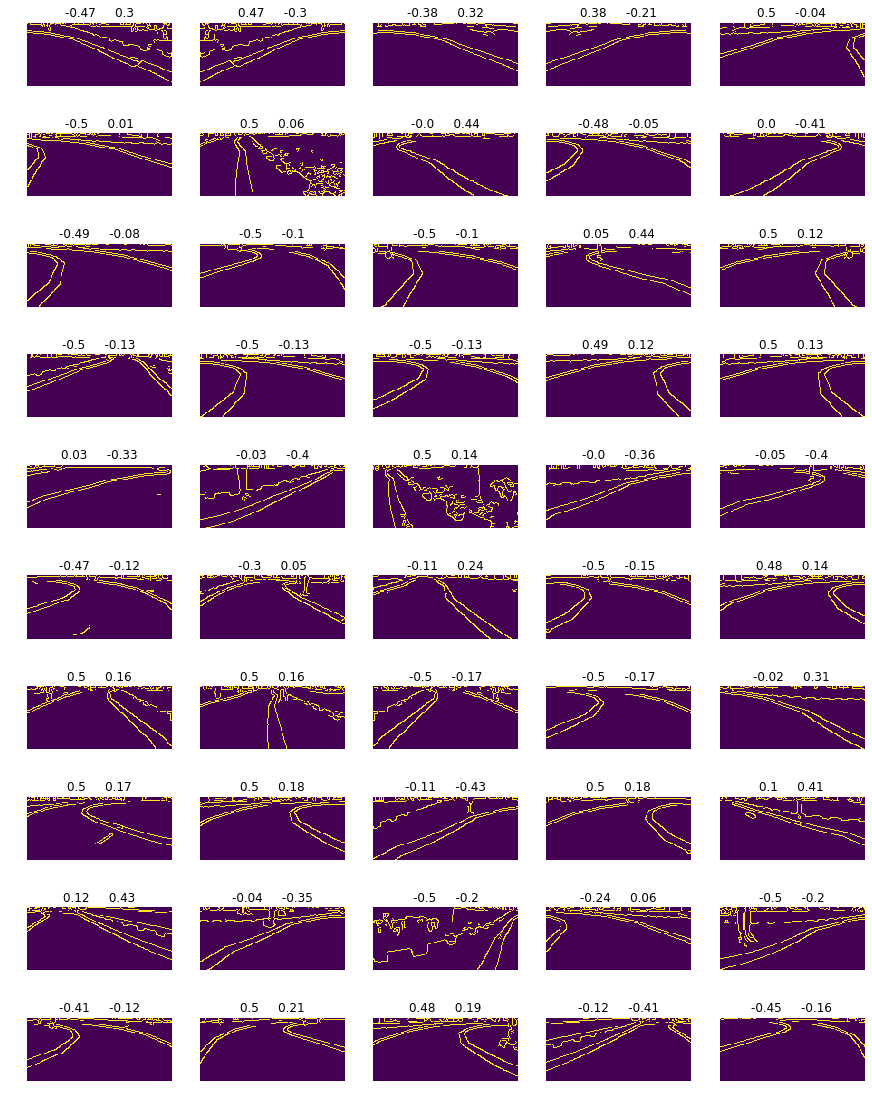

In [21]:
predictions = model.predict(X_test)[:,0]
errors = np.abs(predictions - y_test)
indexes = np.argsort(errors)

fig, axes = plt.subplots(10, 5, figsize=(15,20))

for index, ax in zip(indexes[::-1], axes.flatten()):
    img = X_test[index]
    label = y_test[index]
    pred = predictions[index]
    ax.imshow(np.squeeze(img))
    ax.axis('off')
    ax.set_title(str(round(label, 2)) + "     " + str(round(pred, 2)))